In [9]:
!pip install qulacs
!pip install qulacsvis
!pip install hpelm  # ELMの簡易実装（または自作）

In [4]:
from qulacs import Observable
from sklearn.linear_model import LinearRegression

from qreservoir.datasets import Complex_Fourrier
from qreservoir.encoders import ExpEncoder
from qreservoir.models import QELModel
from qreservoir.reservoirs import RotationReservoir

dataset = Complex_Fourrier(complexity=1, size=1000, noise=0.0)

encoder = ExpEncoder(1, 1, 3) # 1 feature, 1 layer, 1 qubit per feature
reservoir = RotationReservoir(encoder, 0, 10)  # 0 ancilla qubits, 10 depth

observables = [Observable(3) for _ in range(9)] # create observable set
for i, ob in enumerate(observables[:3]):
    ob.add_operator(1.0, f"X {i}")
for i, ob in enumerate(observables[3:6]):
    ob.add_operator(1.0, f"Z {i}")
for i, ob in enumerate(observables[6:]):
    ob.add_operator(1.0, f"Y {i}")

model = QELModel(reservoir, observables, LinearRegression()) # observable is a qulacs Observable object
X, _, y, _ = dataset.get_train_test()
model.fit(X, y)
print(model.score(X, y))

0.8544142621244923


QELModel は 量子特徴写像＋固定ユニタリ＋観測 を使っており、ELMと思想が似ていますが量子性が加わっている。

ELM は古典的なランダム写像＋線形学習。

リッジ回帰は単純な線形モデル。

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import accuracy_score
import numpy as np

# QELModel系
from qulacs import Observable
from qreservoir.encoders import ExpEncoder
from qreservoir.reservoirs import RotationReservoir
from qreservoir.models import QELModel

# ELM実装 (簡易版)
class ELM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.W = np.random.randn(input_dim, hidden_dim)
        self.b = np.random.randn(hidden_dim)
        self.beta = None
        self.output_dim = output_dim

    def _activation(self, x):
        return np.tanh(x)

    def fit(self, X, y):
        H = self._activation(X @ self.W + self.b)
        self.beta = np.linalg.pinv(H) @ y

    def predict(self, X):
        H = self._activation(X @ self.W + self.b)
        return H @ self.beta

# データの準備
data = load_iris()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)

# 二値分類に限定（例：Setosa vs not-Setosa）
y_binary = (y == 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# 1. Ridge回帰
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
print("Ridge Accuracy:", accuracy_score(y_test, ridge.predict(X_test) > 0.5))

# 2. ELM
elm = ELM(input_dim=4, hidden_dim=20, output_dim=1)
elm.fit(X_train, y_train)
print("ELM Accuracy:", accuracy_score(y_test, elm.predict(X_test) > 0.5))

# 3. QELModel（量子リザバー）
encoder = ExpEncoder(4, 1, 1)
reservoir = RotationReservoir(encoder, 0, 5)  # ancilla 0, depth 5

observables = [Observable(4) for _ in range(4)]
for i, ob in enumerate(observables):
    ob.add_operator(1.0, f"Z {i}")

qel = QELModel(reservoir, observables, LinearRegression())
qel.fit(X_train, y_train)
print("QELModel Accuracy:", accuracy_score(y_test, qel.predict(X_test) > 0.5))


Ridge Accuracy: 1.0
ELM Accuracy: 1.0
QELModel Accuracy: 0.9555555555555556


| モデル      | 入力特徴量          | 備考                             |
| -------- | -------------- | ------------------------------ |
| Ridge回帰  | 標準化後の元の特徴量     | sklearn Ridge                  |
| ELM      | ランダム重みで写像した特徴量 | hidden weights × input → relu等 |
| QELModel | 量子観測値（Zなど）     | `model.transform(X)` で取得       |


/home/yu_iana/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


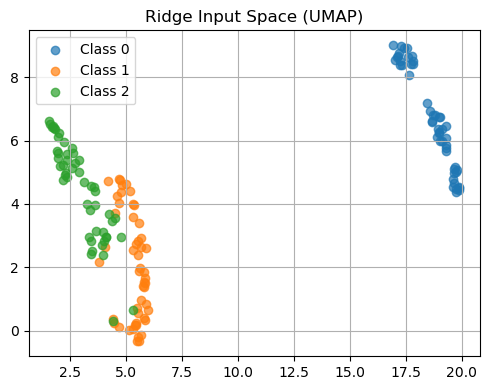

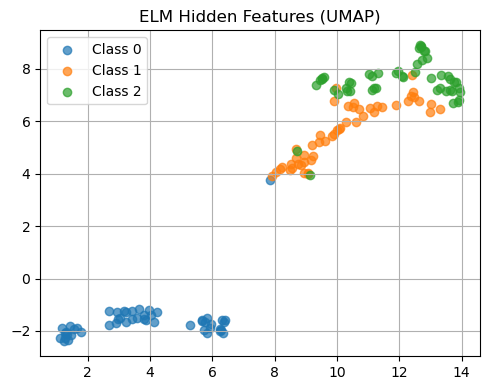

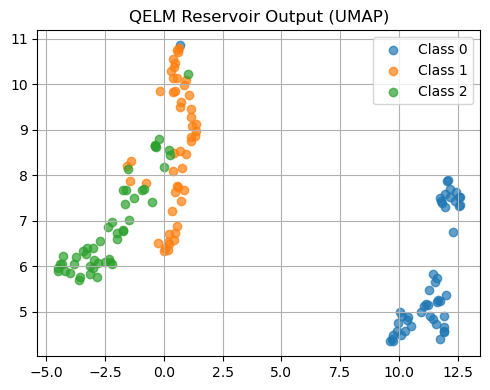

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import umap
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

# ELMライブラリ（または自作で）
from hpelm import ELM  # pip install hpelm

from qreservoir.encoders import ExpEncoder
from qreservoir.reservoirs import RotationReservoir
from qreservoir.models import QELModel
from qulacs import Observable

# データ準備
data = load_iris()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)

# 1. Ridge: 特徴空間 = Xそのまま
features_ridge = X

# 2. ELM: ランダム投影+活性化（ReLU）
elm = ELM(X.shape[1], 3, classification="c", batch=100)# ✅ 出力クラス数 = 3（Iris）
elm.add_neurons(50, "sigm")  # or "lin", "tanh", "relu"
y_onehot = np.eye(3)[y]
elm.train(X, y_onehot)
features_elm = elm.project(X)

# 3. QELModel: 量子観測特徴量
encoder = ExpEncoder(4, 1, 1)
reservoir = RotationReservoir(encoder, 0, 5)
observables = [Observable(4) for _ in range(4)]
for i, ob in enumerate(observables):
    ob.add_operator(1.0, f"Z {i}")
qel = QELModel(reservoir, observables, Ridge())  # 👈 ここに Ridge() を渡す
qel.fit(X, y)
# リザバー出力を取得
reservoir_output = np.array([np.real(reservoir.get_reservoir_state(sample).get_vector()) for sample in X])

# すべてUMAPで2次元に圧縮
umap_model = umap.UMAP(n_components=2, random_state=42)
proj_ridge = umap_model.fit_transform(features_ridge)
proj_elm   = umap_model.fit_transform(features_elm)
proj_qelm = umap_model.fit_transform(reservoir_output)

# 可視化
def plot_projection(proj, title):
    plt.figure(figsize=(5, 4))
    for i in np.unique(y):
        plt.scatter(proj[y==i, 0], proj[y==i, 1], label=f"Class {i}", alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)

plot_projection(proj_ridge, "Ridge Input Space (UMAP)")
plot_projection(proj_elm, "ELM Hidden Features (UMAP)")
plot_projection(proj_qelm, "QELM Reservoir Output (UMAP)")
plt.show()
